In [89]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from pprint import pprint

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.datasets import fashion_mnist
from keras.utils.np_utils import to_categorical
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPool2D, UpSampling2D, Reshape
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

In [77]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [78]:
print("x_train shape: {}, y_train shape: {}".format(x_train.shape, y_train.shape))

x_train shape: (60000, 28, 28), y_train shape: (60000,)


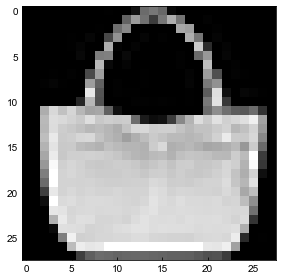

In [79]:
plt.imshow(x_train[100], cmap='gray')

In [80]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1)

In [81]:
x_train = x_train.reshape(len(x_train), 28, 28, 1)
x_val = x_val.reshape(len(x_val), 28, 28, 1)
x_test = x_test.reshape(len(x_test), 28, 28, 1)

In [82]:
print(x_train.shape)
print(x_val.shape)

(54000, 28, 28, 1)
(6000, 28, 28, 1)


In [83]:
x_train = x_train.astype('float32')/255.
x_val = x_val.astype('float32')/255.
x_test = x_test.astype('float32')/255.

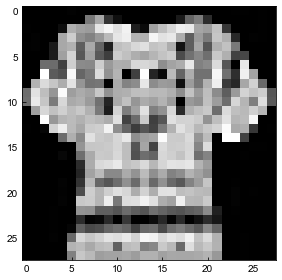

In [84]:
plt.imshow(x_train[10].reshape(28,28), cmap='gray')

In [85]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [90]:
# autoencoder
input_dim = x_train.shape[1]
encoding_dim = 32

compression_factor = float(input_dim)/encoding_dim
print("Compression factor: {}".format(compression_factor))

autoencoder = Sequential()

# Encoder Layers
autoencoder.add(Conv2D(16, (3,3), activation='relu', padding='same',
                      input_shape=x_train.shape[1:]))
autoencoder.add(MaxPool2D((2,2), padding='same'))
autoencoder.add(Conv2D(8, (3,3), activation='relu', padding='same'))
autoencoder.add(MaxPool2D((2,2), padding='same'))
autoencoder.add(Conv2D(8, (3,3), strides=(2,2), activation='relu', padding='same'))

# Flatten encoding for visualization
autoencoder.add(Flatten())
autoencoder.add(Reshape((4, 4, 8)))

# Decoder Layers
autoencoder.add(Conv2D(8, (3,3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2,2)))
autoencoder.add(Conv2D(8, (3,3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2,2)))
autoencoder.add(Conv2D(16, (3,3), activation='relu'))
autoencoder.add(UpSampling2D((2,2)))
autoencoder.add(Conv2D(1, (3,3), activation='sigmoid', padding='same'))

autoencoder.summary()

W0705 12:07:04.319302  8472 deprecation_wrapper.py:119] From C:\Anaconda3\envs\Development\lib\site-packages\keras-2.2.4-py3.7.egg\keras\backend\tensorflow_backend.py:2227: The name tf.image.resize_nearest_neighbor is deprecated. Please use tf.compat.v1.image.resize_nearest_neighbor instead.



Compression factor: 0.875
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 4, 4, 8)           584       
_________________________________________________________________
flatten_5 (Flatten)          (None, 128)               0         
_________________________________________________________________
reshape_2 (Reshape)         

In [92]:
# encoder
encoder = Model(inputs=autoencoder.input, 
               outputs=autoencoder.get_layer('flatten_5').output)

encoder.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12_input (InputLayer) (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 4, 4, 8)           584       
_________________________________________________________________
flatten_5 (Flatten)          (None, 128)               0   

In [93]:
autoencoder.compile(loss='binary_crossentropy', optimizer = 'adam', metrics=["accuracy"])

In [94]:
early_stopping = EarlyStopping(min_delta=1e-4)
hist = autoencoder.fit(x_train, x_train, epochs=100, batch_size=256,
                 validation_data=(x_val, x_val), callbacks=[early_stopping])

Train on 54000 samples, validate on 6000 samples
Epoch 1/100
54000/54000 [==============================] - 5s 97us/step - loss: 0.3768 - acc: 0.4963 - val_loss: 0.3189 - val_acc: 0.5017
Epoch 2/100
54000/54000 [==============================] - 4s 73us/step - loss: 0.3125 - acc: 0.5026 - val_loss: 0.3065 - val_acc: 0.5043
Epoch 3/100
54000/54000 [==============================] - 4s 74us/step - loss: 0.3040 - acc: 0.5043 - val_loss: 0.3008 - val_acc: 0.5049
Epoch 4/100
54000/54000 [==============================] - 4s 73us/step - loss: 0.2997 - acc: 0.5049 - val_loss: 0.2981 - val_acc: 0.5046
Epoch 5/100
54000/54000 [==============================] - 4s 73us/step - loss: 0.2967 - acc: 0.5052 - val_loss: 0.2947 - val_acc: 0.5056
Epoch 6/100
54000/54000 [==============================] - 4s 72us/step - loss: 0.2944 - acc: 0.5055 - val_loss: 0.2927 - val_acc: 0.5057
Epoch 7/100
54000/54000 [==============================] - 4s 72us/step - loss: 0.2925 - acc: 0.5056 - val_loss: 0.2913 - v

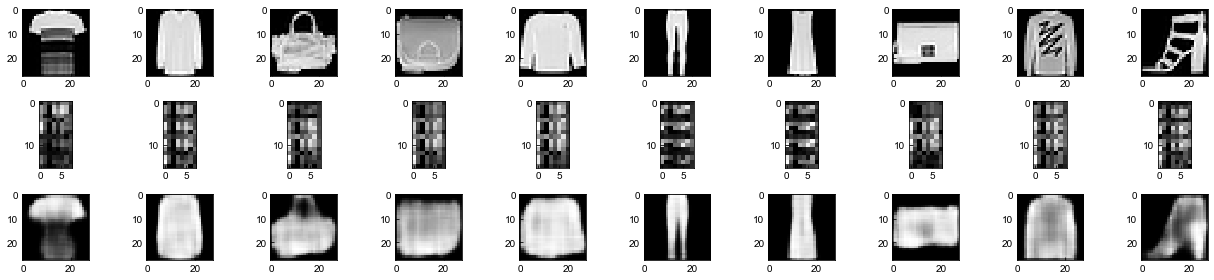

In [96]:
num_images = 10
np.random.seed(42)
random_test_images = np.random.randint(x_test.shape[0], size=num_images)

encoded_imgs = encoder.predict(x_test)
decoded_imgs = autoencoder.predict(x_test)

plt.figure(figsize=(18, 4))

for i, image_idx in enumerate(random_test_images):
    # plot original image
    ax = plt.subplot(3, num_images, i+1)
    plt.imshow(x_test[image_idx].reshape(28,28))
    plt.gray()
    
    # plot encoded image
    ax = plt.subplot(3, num_images, num_images+i+1)
    plt.imshow(encoded_imgs[image_idx].reshape(16,8))
    plt.gray()
    
    # plot decoded image
    ax = plt.subplot(3, num_images, 2*num_images+i+1)
    plt.imshow(decoded_imgs[image_idx].reshape(28,28))
    plt.gray()

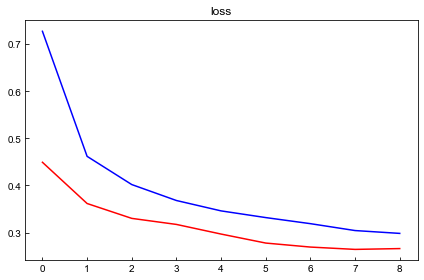

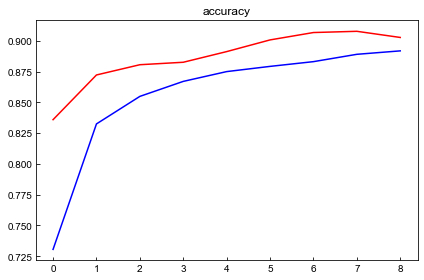

In [21]:
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.title('loss')
plt.show()
plt.plot(hist.history['acc'], color='b')
plt.plot(hist.history['val_acc'], color='r')
plt.title('accuracy')
plt.show()

In [22]:
y_hat = model.predict(x_val)
y_pred = np.argmax(y_hat, axis=1)
y_true = np.argmax(y_val, axis=1)
cm = confusion_matrix(y_true, y_pred)
pprint(cm)

array([[485,   3,  15,  21,   2,   0,  71,   0,   3,   0],
       [  0, 579,   0,   7,   0,   0,   1,   0,   0,   0],
       [  7,   0, 467,   4,  55,   0,  45,   0,   1,   0],
       [  6,   7,   4, 585,  14,   0,  16,   0,   1,   0],
       [  0,   0,  15,  16, 538,   0,  48,   0,   0,   0],
       [  0,   0,   0,   0,   0, 611,   0,  16,   0,   3],
       [ 45,   0,  30,  20,  40,   0, 448,   0,   5,   0],
       [  0,   0,   0,   0,   0,   5,   0, 593,   1,   6],
       [  0,   0,   1,   2,   1,   0,   4,   2, 543,   0],
       [  0,   0,   0,   0,   0,   4,   0,  35,   1, 568]], dtype=int64)


In [87]:
y_hat = model.predict(df_test.values, batch_size=64)
y_pred = np.argmax(y_hat,axis=1)

In [88]:
with open('submission.csv', 'w') as f :
    f.write('ImageId,Label\n')
    for i in range(len(y_pred)) :
        f.write("".join([str(i+1),',',str(y_pred[i]),'\n']))